In [150]:
import numpy as np
import xarray as xr
from pdb import set_trace
import matplotlib.pyplot as plt 
cmap = plt.get_cmap('tab20')
cmap = cmap(np.linspace(0,1,20))[:,None,:]

from dummy import get_samples
%pdb 
N_BOARDS = 5
BOARD_IDS = ['XXX_%02d' % n for n in range (N_BOARDS)]

Automatic pdb calling has been turned OFF


## 6.2 Spirometry kits 

In [34]:
# Make up some data 
a = 0.75 
n = 1.5 
n_samps = 20 
SPIRO_IDS = ['A', 'B', 'C', 'D', 'E']
spiro_data = []
for _ in SPIRO_IDS:
    f = np.random.randint(100,400,n_samps)
    p = (a * (f ** n)) + (100 * (np.random.rand(n_samps) - 0.5))
    spiro_data.append(np.vstack((f, p)).T)

spiro_data = np.stack(spiro_data, axis=-1)
spiro_data = xr.DataArray(spiro_data, [
    ('measurement', range(n_samps)), 
    ('variable', ['flow', 'reading']), 
    ('spiro', SPIRO_IDS)
])

In [35]:
# Perform sub-quadratic fit 
all_f = spiro_data.loc[:,'flow',:].data.flatten()
all_p = spiro_data.loc[:,'reading',:].data.flatten()
(n, loga) = np.polyfit(np.log(all_f), np.log(all_p), 1)

a = np.exp(loga)
print("a:", a, "n:", n)
rms_error = np.sqrt(((all_p - (a * all_f ** n))**2).mean())
print("RMS error (normalised %)", 100 * rms_error / all_p.mean())

a: 0.7486130780987429 n: 1.5004944256794568
RMS error (normalised %) 0.9693189356400634


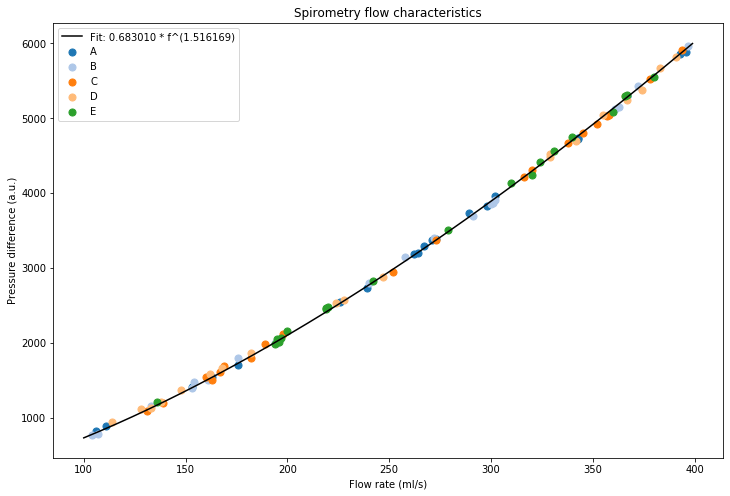

In [41]:
# Evaluate fit against data 
fig = plt.figure(figsize=(12,8))
fig.set_size_inches(12,8)
flow_range = np.arange(100, 400)
plt.plot(flow_range, a * (flow_range ** n), color='k')
for bidx,b in enumerate(SPIRO_IDS): 
    data = spiro_data.loc[:,:,b]
    plt.scatter(x=data[:,0], y=data[:,1], c=cmap[bidx], s=50)

plt.legend(['Fit: %.6f * f^(%.6f)' % (a, n)] + SPIRO_IDS)
plt.title("Spirometry flow characteristics")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

## 6.1 Flow measurement 

In [42]:
# Make up some data 
a = 0.75 
n = 1.5 
flow_targets = [150, 200, 225, 250, 275, 300, 350]
flow_stds = [5, 5, 8, 9, 10, 15, 15]
flow_data = []
for _ in range(N_BOARDS):
    dp = get_samples(flow_targets, flow_stds, 1, 10)
    dp[:,1] = a * (dp[:,1] ** n)
    flow_data.append(dp)

flow_data = np.stack(flow_data, axis=2)
flow_data = xr.DataArray(flow_data,[ 
    ('measurement', np.arange(flow_data.shape[0])), 
    ('variable', ['flow', 'reading']), 
    ('board', BOARD_IDS)
])

### Non-quadratic fit with variable weighting
Based on observations of the data, it was decided to relax the quadratic constraint on the fit and permit a non-integer exponent. This presumably reflects imperfections in the system compared to the ideal theoretical case. At any rate, such a deviation from the theoretical fit can be justified if it better matches the data actually obtained. The fit was biased towards the range 200-300 ml/s to promote high accuracy in the middle of the design range at the expense of high/low flow extremes. The new fit took the form $\Delta P = af^n$. 

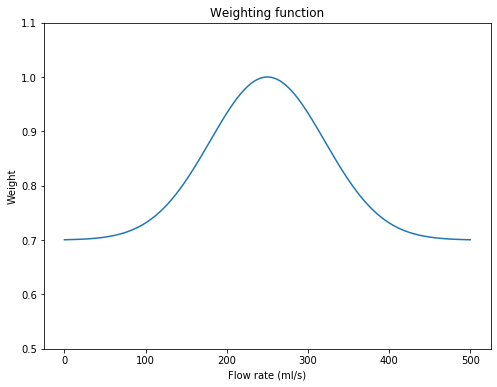

In [38]:
# weighting function 
# The distribution is a modified Gaussian 
def weight_window(x):
    shifted = x - 250 # centre of the fit 
    dropoff = 0.3     # relative drop off in weight at edges 
    return (1-dropoff) + (dropoff * np.exp(-shifted**2/1e4))

x = np.linspace(0,500,500)
w = weight_window(x)
plt.figure(figsize=(8,6))
plt.plot(x, w)
plt.ylim(0.5,1.1)
plt.title("Weighting function")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Weight")
plt.show()

In [39]:
# Peform the fit in log space, evaluate error  
all_f = flow_data.loc[:,'flow',:].data.flatten()
all_p = flow_data.loc[:,'reading',:].data.flatten()
(n, loga) = np.polyfit(np.log(all_f), np.log(all_p), 
    1, w=weight_window(all_f))

a = np.exp(loga)
print("a:", a, "n:", n)
rms_error = np.sqrt(((all_p - (a * all_f ** n))**2).mean())
print("RMS error (normalised %)", 100 * rms_error / all_p.mean())

a: 0.683009544637747 n: 1.516168709174682
RMS error (normalised %) 6.843323435880515


### Evaluate fit against data 

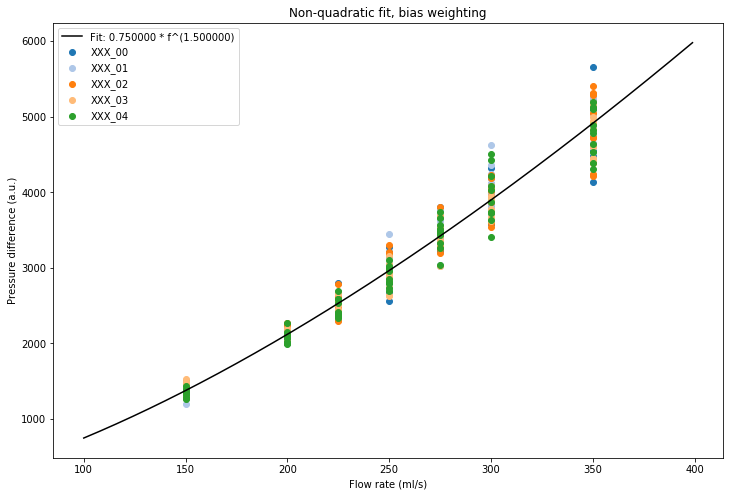

In [43]:
fig = plt.figure(figsize=(12,8))
flow_range = np.arange(100, 400)
plt.plot(flow_range, a * (flow_range ** n), color='k')
for bidx,b in enumerate(BOARD_IDS): 
    data = flow_data.loc[:,:,b]
    plt.scatter(x=data[:,0], y=data[:,1], c=cmap[bidx])

plt.legend(['Fit: %.6f * f^(%.6f)' % (a, n)] + BOARD_IDS)
plt.title("Non-quadratic fit, bias weighting")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.savefig('flow-pressure.png', dpi=600)
plt.show()

## 6.3 Tidal volume drift

In [77]:
# Make up some data 
samps = 10 
VT_NOM = 400 

vt_data = [] 
for _ in BOARD_IDS: 
    vols = []
    for hr in np.arange(0, 12.5, 0.5):
        a = np.random.normal(400, 10, 10)
        e = a + np.random.normal(0, 5, 10) + 5
        vols.append(np.vstack((hr * np.ones_like(a), e, a)).T)
    vt_data.append(np.concatenate(vols, axis=0))
    
vt_data = np.stack(vt_data, axis=2)
vt_data = xr.DataArray(vt_data,[ 
    ('time', np.arange(vt_data.shape[0])), 
    ('variable', ['time', 'estimated', 'actual']), 
    ('board', BOARD_IDS)
])

In [ ]:
# Evaluate mean drift function here?
# Run a regression of true difference vs time, show very weak dependence 
# Investigate covariance?

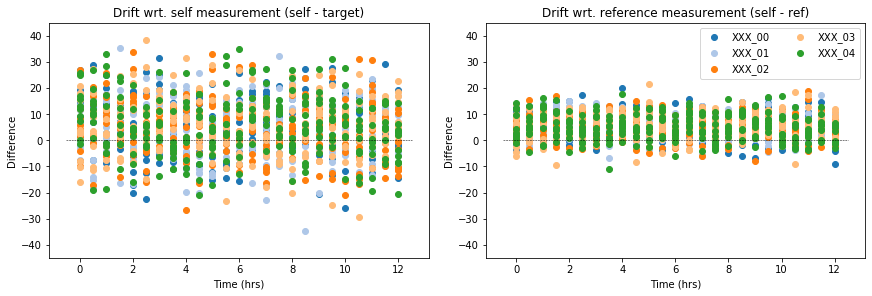

In [90]:
# Plot all data 
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

for bidx,b in enumerate(BOARD_IDS): 
    data = vt_data[:,:,bidx]
    time = data[:,0]
    est = data[:,1]
    ref = data[:,2]
    y1 = (est - 400)
    y2 = (est - ref)
    axes[0].scatter(x=time, y=y1, c=cmap[bidx])
    axes[1].scatter(x=time, y=y2, c=cmap[bidx])  
    
axes[0].set_title('Drift wrt. self measurement (self - target)')
axes[1].set_title('Drift wrt. reference measurement (self - ref)')
axes[1].legend(BOARD_IDS, ncol=2)

for ax in axes:
    ax.set_ylim(-45, 45)
    ax.plot([-0.5, 12.5], [0, 0], 'k--', linewidth=0.5)
    ax.set_xlabel('Time (hrs)')
    ax.set_ylabel('Difference (ml)')

plt.show()

## 6.4 Inspiration pressure 

In [156]:
# Make up some data - pressure profile during inspiraiton 
from scipy.signal import gaussian 
cycles = 3 
nsamps = 50
PINSPS = [35, 37, 39, 41, 43, 45]
press_data = []
for pinsp in PINSPS: 
    pdata = []
    for _ in range(cycles): 
        p = (pinsp * gaussian(nsamps, 7)) + np.random.normal(0,1,nsamps)
        pdata.append(np.vstack((pinsp * np.ones(nsamps), p)).T)
    press_data.append(np.stack(pdata, axis=-1))
    
press_data = np.stack(press_data, axis=-1)

press_data = xr.DataArray(press_data,[ 
    ('sample', np.arange(press_data.shape[0])), 
    ('variable', ['pinsp', 'reading']), 
    ('cycle', np.arange(press_data.shape[2])),
    ('pressure', PINSPS)
])


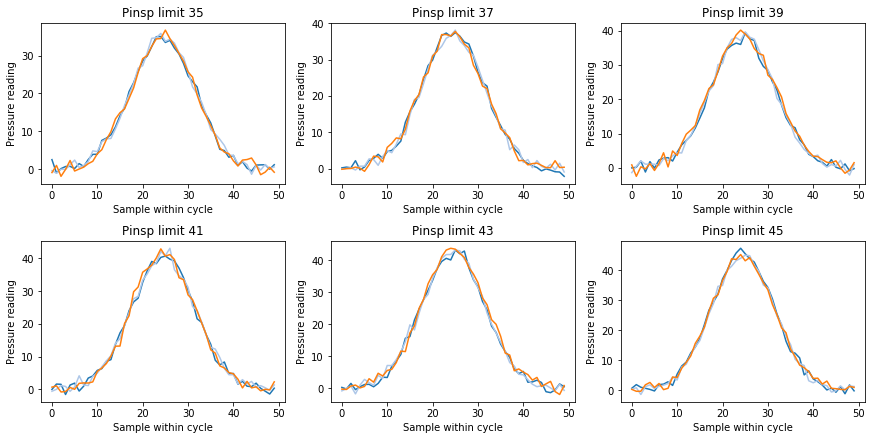

In [158]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(12,6))

for axidx, (ax, pinsp) in enumerate(zip(axes.flatten(), PINSPS)): 
    for cycle in press_data.coords['cycle']: 
        data = press_data.loc[:,:,cycle,pinsp]
        fltr = (data[:,0] == PINSPS[axidx])
        ax.plot(data[fltr,1], color=np.squeeze(cmap[cycle]))
        
    ax.set_title("Pinsp limit {}".format(PINSPS[axidx]))
    ax.set_xlabel('Sample within cycle')
    ax.set_ylabel('Pressure reading')

plt.show()

## 6.6 Low flow control stability 

In [160]:
nsamps = 50 
vt_data = np.random.normal(250, 15, (nsamps ,len(BOARD_IDS)))

vt_data = xr.DataArray(vt_data, [
    ('sample', range(nsamps)), 
    ('board', BOARD_IDS)
])

In [180]:
# Did any boards fail the test?
threshold = 215
_, fail_ids = np.where(vt_data < threshold)
fail_ids = np.unique(fail_ids)
print("Failing boards:", [ BOARD_IDS[b] for b in fail_ids ])

Failing boards: ['XXX_02', 'XXX_03', 'XXX_04']


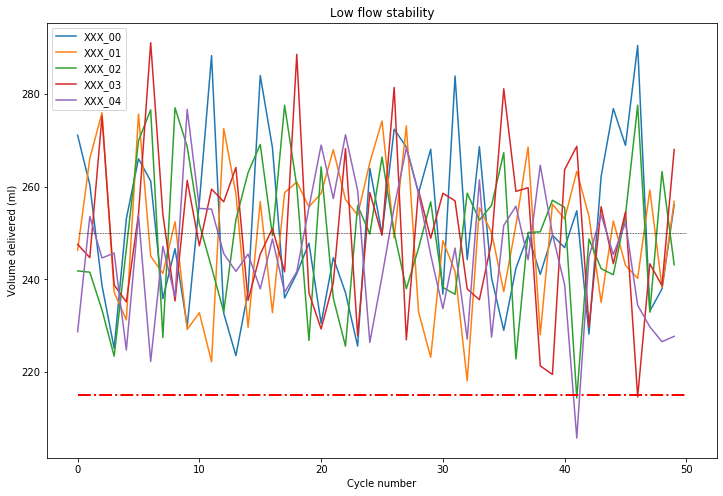

In [181]:
fig = plt.figure(figsize=(12,8))
plt.plot(vt_data)

plt.plot([0, 50], [250, 250], 'k--', linewidth=0.5)
plt.plot([0, 50], 2*[threshold], 'r-.', linewidth=2)
plt.title('Low flow stability')
plt.xlabel('Cycle number')
plt.ylabel('Volume delivered (ml)')
plt.legend(BOARD_IDS)
plt.show()